# Deep Learning Project 2 - Group 6
Catarina Oliveira | 20211616;
Inês Vieira | 20211589;
Rita Centeno | 20211579


## **Building the Model**

#### Table of Contents:
1. [Library Imports](#import-libraries)
2. [Open Data](#opening-data)
3. [EDA](#eda)
4. [Preprocessing](#initial-preprocessing)
5. [Train Test Split](#train-test-split)
6. [Oversampling](#oversampling)
7. [Modeling](#modeling)
8. [Model Evaluation](#model-evaluation)
9. [Exports](#exports)

### Importing Necessary Libraries
<a id='import-libraries'></a>

In [1]:
# Imports

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow
# !pip install pillow
# !pip install opencv-python
# !pip install scikit-learn
# !pip install keras
# !pip install imbalanced-learn
# !pip install opencv-contrib-python



# Importing standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf

# Importing image libraries
from PIL import Image #, ImageEnhance
import cv2
# from cv2 import dnn_superres
# Importing scikit-learn libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Importing Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import ReduceLROnPlateau
# from keras import regularizers

# Importing imblearn libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Import pretrained models
# from tensorflow.keras.applications import (ResNet50, InceptionV3, DenseNet121, VGG16, Xception)

# Importing model evaluation libraries
# from tensorflow.keras.models import load_model

# Import garbage collector to free up memory
import gc

# Import warnings to silence warnings
import warnings
warnings.filterwarnings('ignore')

# Importing custom functions
from path import path
from utils import *

%load_ext autoreload
%autoreload 2

### Opening Data
<a id='opening-data'></a>

#### Metadata

In [2]:
metadata = pd.read_csv(path + "DataDL\\metadata.csv")

In [3]:
metadata.head()

,Image ID,Label
0,OAS1_0308_MR1_mpr-1_125.jpg,NaN
1,OAS1_0351_MR1_mpr-3_112.jpg,NaN
2,OAS1_0308_MR1_mpr-1_131.jpg,Moderate Dementia
3,OAS1_0351_MR1_mpr-3_106.jpg,Moderate Dementia
4,OAS1_0308_MR1_mpr-1_119.jpg,Moderate Dementia


In [4]:
# Check for duplicated rows
metadata['Image ID'].duplicated().sum()

0

In [5]:
# Check for missing values
metadata.isnull().sum()

Image ID    0
Label       9
dtype: int64

In [6]:
# Drop the 9 rows with missing values
metadata.dropna(inplace=True)

#### Images

In [7]:
# Paths
train_dir = path + "DataDL\\train\\"
test_dir = path + "DataDL\\test\\"

In [8]:
# Create empty lists to store labels and the arrays of images
labels_train = []
images_train = []
labels_test = []
images_test = []

# Load images and labels
for index, row in metadata.iterrows():
    image_name = row['Image ID']
    label = row['Label']

    # Check if the image belongs to the training set
    if os.path.exists(os.path.join(train_dir, image_name)):

        # Load image
        image_path = os.path.join(train_dir, image_name) 
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assign image to train set
        metadata.at[index, 'train'] = 1 
           
        # Append image and respective label to list
        labels_train.append(label) 
        images_train.append(img)

    elif os.path.exists(os.path.join(test_dir, image_name)):

        # Load image
        image_path = os.path.join(test_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assign image to test set
        metadata.at[index, 'train'] = 0

        # Append image and respective label to list
        labels_test.append(label)
        images_test.append(img)

    # Error message if image is not found
    else:
        print(f"Image not found: {image_name}")

In [9]:
del train_dir, test_dir, image_name, label, image_path, img, index, row
gc.collect()

57

### EDA
<a id='eda'></a>

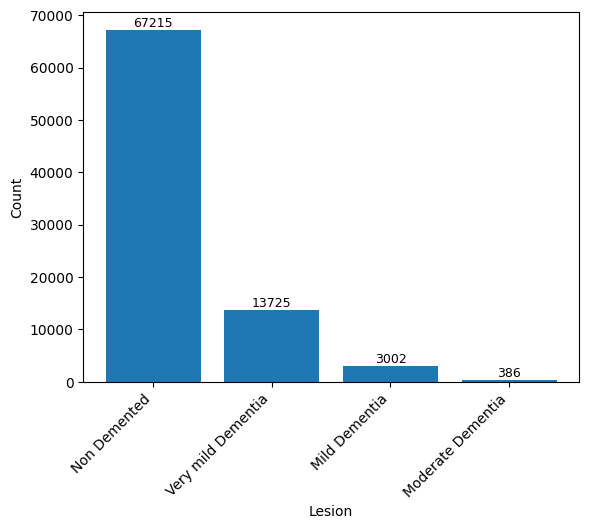

In [10]:
# Check the target variable's distribution
bar_chart(metadata, 'Label', 'Lesion', fontsize=9, rotation=45)

In [11]:
all_images = images_train + images_test
# Assuming 'images' is your list of numpy arrays
first_image_shape = all_images[0].shape

# Check if all images have the same shape as the first image
for img in all_images[1:]:
    if img.shape != first_image_shape:
        print("Images do not have the same shape.")
        break
else:
    print(f"All images have the same shape. \nShape: {first_image_shape}")

All images have the same shape. 
Shape: (248, 496)


### Initial Preprocessing
<a id='initial-preproc'></a>

Keep track of original indexes

In [12]:
# Create a column with the original index for later checks
metadata['original_index'] = metadata.index

# Divide the metadata into the train and test sets and reset respective indices
metadata_train = metadata[metadata['train'] == 1].drop(['train'], axis=1)
metadata_test = metadata[metadata['train'] == 0].drop(['train'], axis=1)

metadata_train = metadata_train.reset_index(drop=True)
metadata_test = metadata_test.reset_index(drop=True)

# Create a column with the original train set index for later checks
metadata_train['original_train_index'] = metadata_train.index
metadata_test['original_test_index'] = metadata_test.index

In [13]:
del metadata
gc.collect()

3464

Encode labels

In [14]:
# Converting labels to numpy arrays
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

# Defining the encoder
labelEncoder = LabelEncoder()

# Tranform train and test labels into numerical data
labels_train = labelEncoder.fit_transform(labels_train)
labels_test = labelEncoder.transform(labels_test)

# Check the encoding correspondance
label_mapping = {i: label for i, label in enumerate(labelEncoder.classes_)}
print(', '.join(f'{encoded}: {original}' for encoded, original in label_mapping.items()))

0: Mild Dementia, 1: Moderate Dementia, 2: Non Demented, 3: Very mild Dementia


Undersampling for computational reasons

In [15]:
sampling_strategy = {
    'Very mild Dementia': 3500,
    'Non Demented': 3500,
    # 'Mild Dementia': 2500
}

undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=46)
metadata_train_under, y_under = undersample.fit_resample(metadata_train, metadata_train['Label'])


In [16]:
del undersample, sampling_strategy
gc.collect()

0

In [17]:
# Create the oversampled lists of images and labels and store them as numpy arrays
images_train_under = np.array([images_train[i] for i in metadata_train_under['original_train_index']])
labels_train_under = np.array([labels_train[i] for i in metadata_train_under['original_train_index']])

# Drop the new index column as it's no longer needed
# metadata_train_under = metadata_train_under.drop(['original_train_index'], axis=1)

# Reset the undersampled metadata index
metadata_train_under.reset_index(drop=True, inplace=True)

In [18]:
del images_train, labels_train, metadata_train

In [19]:
# Extract hair, resize, normalize train and test images
preproc_images_train = inicial_preproc(images_train_under)
# preproc_images_test = inicial_preproc(images_test)

In [ ]:
# del images_data_test
# gc.collect()

### Train Test Split
<a id='train-test-split'></a>

In [22]:
# Train test split
X_train, X_val, y_train, y_val, metadata_train, metadata_val = train_test_split(
    preproc_images_train, 
    labels_train_under, 
    metadata_train_under, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=46, 
    stratify=labels_train_under, 
    shuffle=True
)

### Oversampling
<a id='oversampling'></a>

In [23]:
metadata_train

,Image ID,Label,original_index,original_train_index
9195,OAS1_0179_MR1_mpr-3_109.jpg,Very mild Dementia,80518,64420
362,OAS1_0316_MR1_mpr-2_134.jpg,Mild Dementia,81769,65423
406,OAS1_0053_MR1_mpr-3_160.jpg,Mild Dementia,81819,65467
3082,OAS1_0348_MR1_mpr-4_102.jpg,Non Demented,50593,40384
4489,OAS1_0103_MR1_mpr-4_140.jpg,Non Demented,16132,12867
...,...,...,...,...
3093,OAS1_0176_MR1_mpr-2_110.jpg,Non Demented,49655,39654
6294,OAS1_0243_MR1_mpr-4_154.jpg,Very mild Dementia,74613,59711
7007,OAS1_0243_MR1_mpr-1_159.jpg,Very mild Dementia,74895,59938
4446,OAS1_0359_MR1_mpr-4_118.jpg,Non Demented,40741,32494


In [24]:
# Creating a column with the current index to later make the oversampling image associations easier
metadata_train['new_index'] = range(len(metadata_train))

In [26]:
# Define the oversampling strategy
# - dont oversample the majority class
# - oversample the minority classes to half of the majority class

sampling_strategy = {
    'Mild Dementia': 3500,
    'Moderate Dementia': 3500,
    # 'Non Demented': 3500,
    # 'Very mild Dementia': 3500
}

# Oversample the train set
oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=46)
metadata_train_over, y_over = oversample.fit_resample(metadata_train, metadata_train['Label'])


In [27]:
metadata_train_over

,Image ID,Label,original_index,original_train_index,new_index
0,OAS1_0179_MR1_mpr-3_109.jpg,Very mild Dementia,80518,64420,0
1,OAS1_0316_MR1_mpr-2_134.jpg,Mild Dementia,81769,65423,1
2,OAS1_0053_MR1_mpr-3_160.jpg,Mild Dementia,81819,65467,2
3,OAS1_0348_MR1_mpr-4_102.jpg,Non Demented,50593,40384,3
4,OAS1_0103_MR1_mpr-4_140.jpg,Non Demented,16132,12867,4
...,...,...,...,...,...
12595,OAS1_0308_MR1_mpr-1_106.jpg,Moderate Dementia,342,272,3234
12596,OAS1_0351_MR1_mpr-3_116.jpg,Moderate Dementia,103,81,4204
12597,OAS1_0351_MR1_mpr-3_116.jpg,Moderate Dementia,103,81,4204
12598,OAS1_0308_MR1_mpr-1_134.jpg,Moderate Dementia,79,63,3399


# TENTATIVAS PREPROC

In [ ]:
# PREPROC BY BINGAI

# import numpy as np
import cv2

# assuming 'images' is your list of numpy arrays
preprocessed_images = []
# reference_image = images[0]

for img in images_train:
    # Inhomogeneity correction: adjust the histogram of the image
    img_corrected = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    # Rigid registration: for this, you need a reference image to which others will be registered
    # Here, we'll use the first image in the list as the reference
    reference_image = images_train[0]
    
    # Find the transformation that aligns the image with the reference
    matrix, _ = cv2.estimateAffine2D(img_corrected, reference_image)
    
    # Apply the transformation
    registered_image = cv2.warpAffine(img_corrected, matrix, (img.shape[1], img.shape[0]))
    
    preprocessed_images.append(img_corrected)


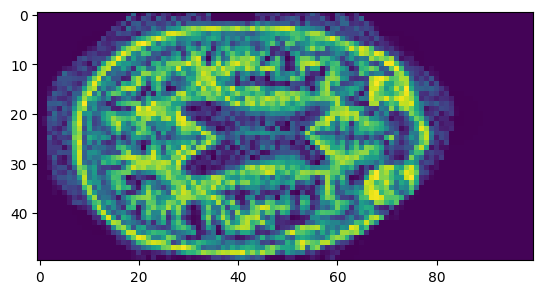

In [20]:
img = preproc_images_train[0]
plt.imshow(img)

In [ ]:
img = cv2.imread('mri.jpg')
img_resized = cv2.resize(img, (100, 50))
plt.imshow(img_resized)

In [ ]:
image = cv2.imread('mri.jpg')
plt.imshow(image)
img_corrected = exposure.equalize_adapthist(img, clip_limit=0.03)
plt.imshow(img_corrected)

In [ ]:
from mtcnn.mtcnn import MTCNN

# Initialize the MTCNN model
detector = MTCNN()

# Load an image from the OASIS dataset
image = cv2.imread('mri.jpg')

# Detect faces in the image
result = detector.detect_faces(image)

# Get the coordinates of the eyes
for face in result:
    left_eye = face['keypoints']['left_eye']
    right_eye = face['keypoints']['right_eye']

# Create a mask for the eyes
mask = np.zeros_like(image)
cv2.rectangle(mask, (left_eye[0]-10, left_eye[1]-10), (right_eye[0]+10, right_eye[1]+10), (255,255,255), -1)

# Apply the mask to the image
masked_image = cv2.bitwise_and(image, mask)

# Now you can preprocess the masked_image and use it in your Keras model


In [ ]:
from skimage import exposure
img = cv2.imread('mri.jpg', cv2.IMREAD_GRAYSCALE)
img_corrected = exposure.equalize_adapthist(img, clip_limit=0.03)
img_corrected

In [ ]:
# Extract hair, resize, normalize train and test images
preproc_images_data_train = inicial_preproc(images_data_train)
preproc_images_data_test = inicial_preproc(images_data_test)

In [ ]:
img = cv2.imread('mri.jpg', cv2.IMREAD_GRAYSCALE)
img

o que isto chaam-se super Resolution, e é basicamente um upscaling sem perder muita qualidade

In [ ]:
images = images_data_train.copy()

In [ ]:
preprocessed_images = []

for img in images:

    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read the desired model
    path = "FSRCNN_x2.pb"
    sr.readModel(path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("fsrcnn", 3)

    # Upscale the image
    result = sr.upsample(img)

    # Save the image
    preprocessed_images.append(result)

    #cv2.imwrite("upscaled.png", result)
